In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
dataframe_train = pd.read_csv('BATADAL_dataset04.csv')
dataframe_test = pd.read_csv('BATADAL_test_dataset.csv')

# Preprocess training data
train_data = dataframe_train.drop(dataframe_train.columns[[0, -1]], axis=1)  # Remove date and label columns
train_labels = dataframe_train.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Preprocess testing data
test_data = dataframe_test.drop(dataframe_test.columns[[0, -1]], axis=1)  # Remove date and label columns
test_labels = dataframe_test.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Normalize data using training dataset stats
min_val = train_data.min().min()
max_val = train_data.max().max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Reshape data to 2D format (height=1, width=num_features, channels=1) for CNN
train_data = np.reshape(train_data.values, (-1, train_data.shape[1], 1))
test_data = np.reshape(test_data.values, (-1, test_data.shape[1], 1))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7101 - loss: 0.6750 - val_accuracy: 0.1948 - val_loss: 0.7600
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.5734 - val_accuracy: 0.1948 - val_loss: 0.8563
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.4630 - val_accuracy: 0.1948 - val_loss: 1.0329
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.3261 - val_accuracy: 0.1948 - val_loss: 1.3654
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.1845 - val_accuracy: 0.1948 - val_loss: 1.9103
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0842 - val_accuracy: 0.1948 - val_loss: 2.5756
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0361 - val_accuracy: 0.1948 - val_loss: 3.1954
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.1948 - val_loss: 

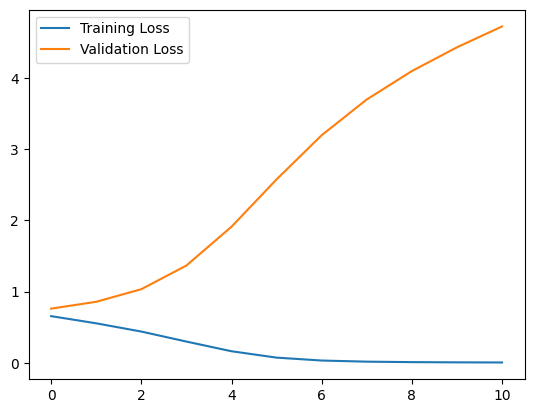

In [ ]:
# CNN model for classification
class AnomalyDetectorCNN(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetectorCNN, self).__init__()
        self.conv1 = layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(train_data.shape[1], 1))
        self.pool1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(64, 3, activation='relu', padding='same')
        self.pool2 = layers.MaxPooling1D(2, padding='same')

        self.conv3 = layers.Conv1D(128, 3, activation='relu', padding='same')
        self.pool3 = layers.MaxPooling1D(2, padding='same')

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate and compile the CNN model
custom_learning_rate = 0.0001 # custom learning rate to lower learning rate to avoid overfitting
optimizer = Adam(learning_rate=custom_learning_rate)
cnn_model = AnomalyDetectorCNN()
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the CNN model on the training data
history = cnn_model.fit(
    train_data, train_labels,
    epochs=20,
    batch_size=512,
    validation_data=(test_data, test_labels),
    shuffle=True,
    callbacks=[early_stopping] # Pass the callback to the fit method
)

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
_# Make predictions on the entire test dataset
test_predictions = cnn_model.predict(test_data)
test_predictions = (test_predictions > 0.5).astype(int)

# Evaluate metrics
def print_stats(predictions, labels):
    print("Accuracy:", accuracy_score(labels, predictions))
    print("Precision:", precision_score(labels, predictions))
    print("Recall:", recall_score(labels, predictions))
    print("F1 Score:", f1_score(labels, predictions))

# Print the evaluation metrics
print_stats(test_predictions, test_labels)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.1948300622307324
Precision: 0.1948300622307324
Recall: 1.0
F1 Score: 0.3261217948717949
